# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver
import os


import time
import numpy as np


from utils import plot_forward_results, create_random_circle_object, plot_probes

PETSc4Py is not installed. PWEPetscFullPinTSolver will not work without it.


### 2. Create Simulated Sample and Space

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=6.35e-7,  # meters (0.635 μm). Visible light
    diameter=10e-6,  # [m]
    focus=-5e-6,  # focal length [m]
)
n_medium = 1.0  # Refractive index of surrounding medium

In [3]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 50  # Resolution
pad_factor = 2.5  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = False

# Thickness Discretization (Pixels)
points_per_wavelength = 16  # Points per Wavelength for Parallel Wave Equation Solver
# nz = 50  # Slices for Multi-Slice
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=n_medium,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

2025-12-12 13:58:11,156 - INFO - === Scan Summary ===
2025-12-12 13:58:11,159 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-12 13:58:11,161 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-12 13:58:11,164 - INFO -   Sample Pixels:          7501 px
2025-12-12 13:58:11,166 - INFO -   Step size:              50 px
2025-12-12 13:58:11,168 - INFO -   Number of scan points:  60
2025-12-12 13:58:11,169 - INFO -   Steps in z:             1007
2025-12-12 13:58:11,172 - INFO -   Probe diameter:         1.000e-05 m
2025-12-12 13:58:11,173 - INFO -   Probe Pixels:           500 px
2025-12-12 13:58:11,174 - INFO -   Max Overlap:            9.000e-06 m
2025-12-12 13:58:11,176 - INFO -   Percentage Overlap:     90.00%



Padding/Overlap: 4501


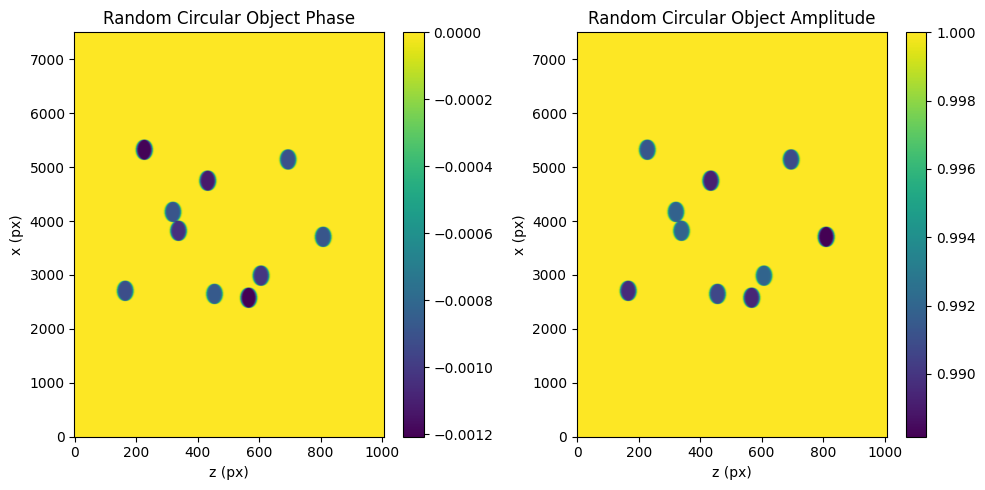

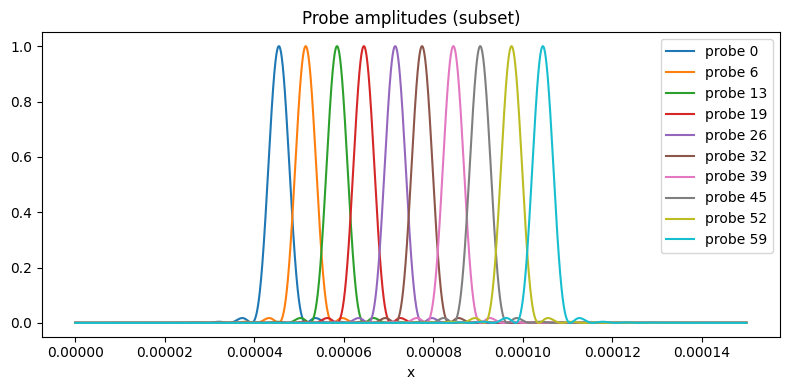

In [5]:
ptycho_object = create_ptycho_object(simulation_space)

ptycho_object = create_random_circle_object(simulation_space, ptycho_object)


# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

plot_probes(simulation_space, ptycho_probes)

### 3. Generate Data with Fine nz Discretization

Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [6]:
# Solve Full Space Space, Iterative
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type="impedance"
)

# Iterative solution
u_fine = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew = forward_model_pwe.get_exit_waves(u_fine)
data = forward_model_pwe.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

Forward model creation and solving time: 44.33 seconds.



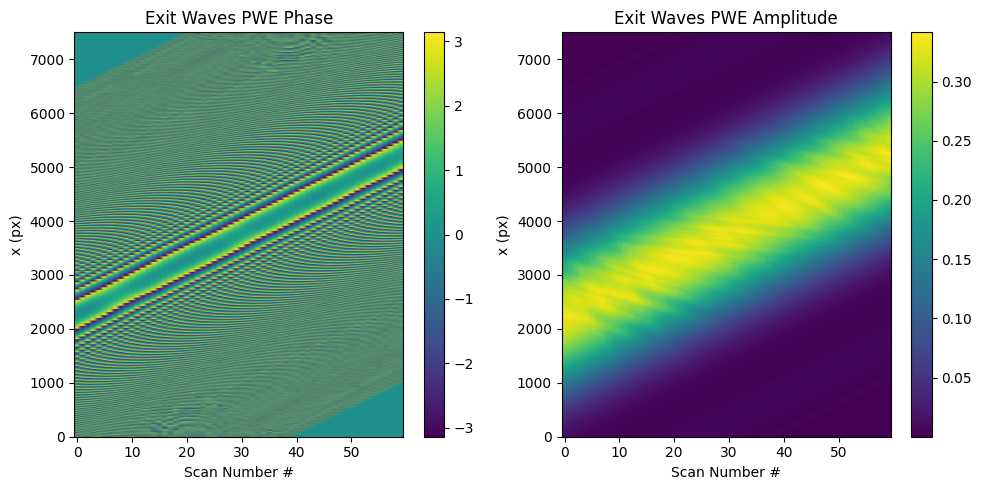

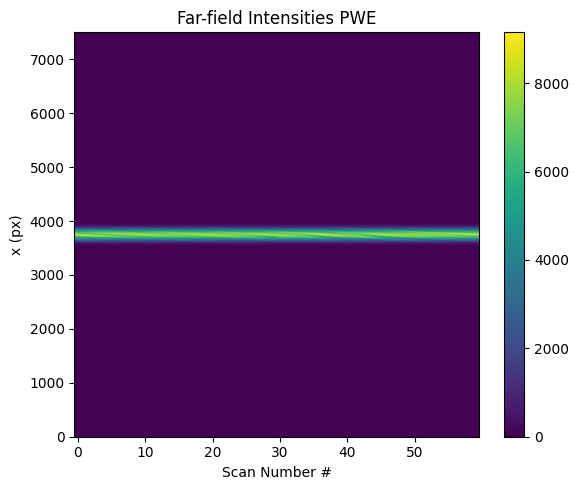

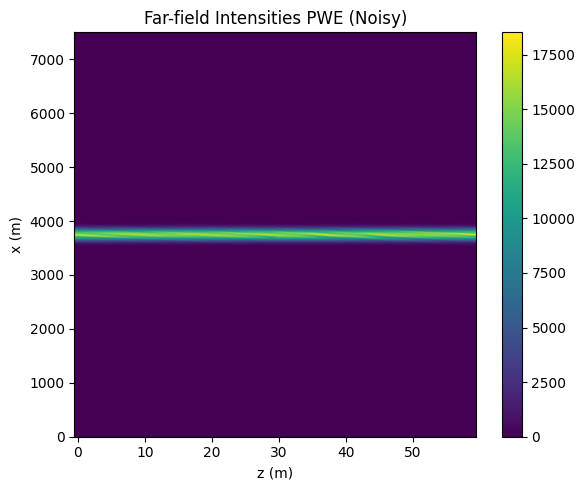

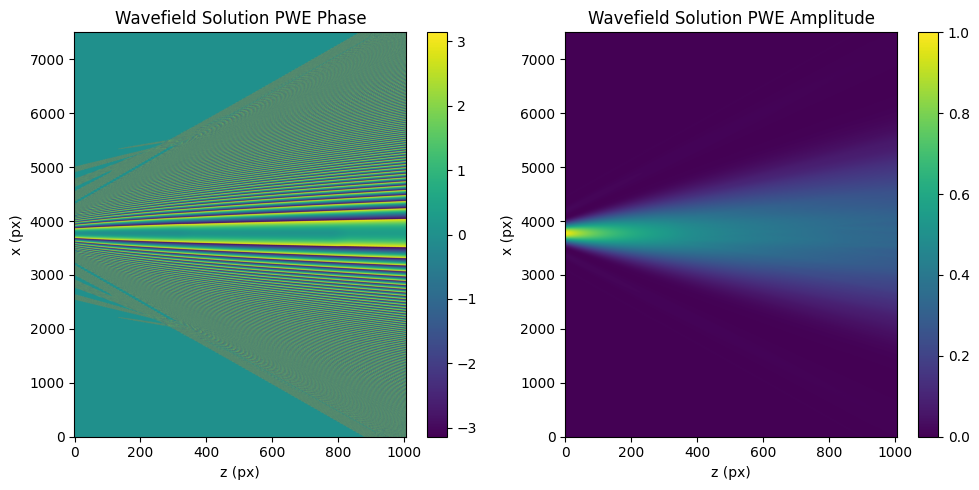

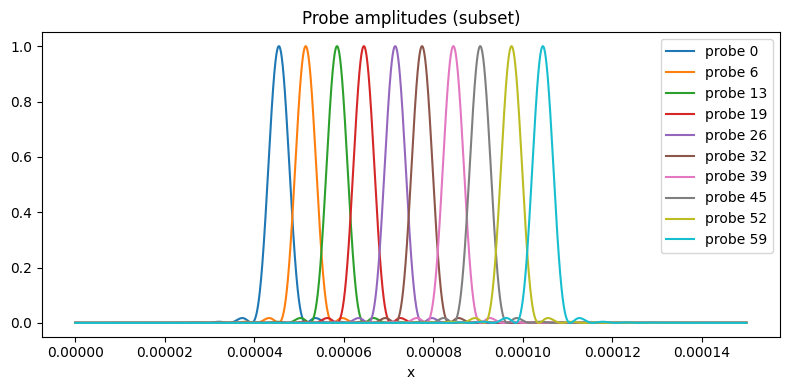

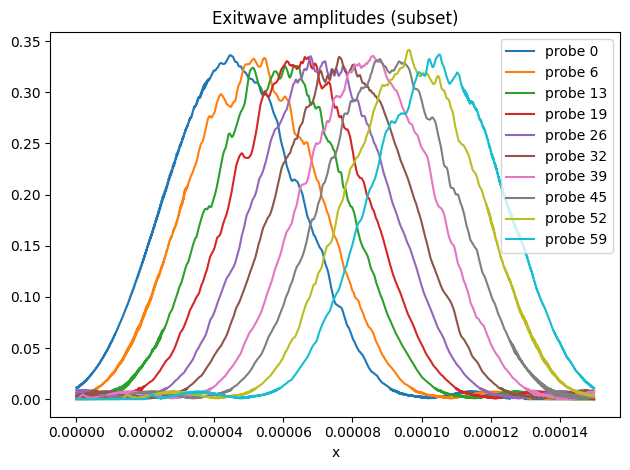

In [7]:
plot_forward_results(simulation_space, data=data, exitwaves=data_ew, solution=u_fine)

In [ ]:
# import pickle
from dataclasses import asdict

np.savez_compressed(
    os.path.join("./results", "simulated_data.npz"),
    sim_config=asdict(sim_config),
    intensity=data,
    exit_waves=data_ew,
    ref_index=ptycho_object.refractive_index,
)